# Bayesian filtering for linear Gaussian dynamical systems

Wouter Kouw | Last update: 09-12-2021

Consider a discrete-time dynamical system with noisy observations $y_k \in \mathbb{R}^{d_y}$ and latent states $x_k \in \mathbb{R}^{d_x}$. We can express the dynamics in the form of a state-space model:

$$\begin{align}
x_k =&\ Ax_{k-1} + q_{k-1} \\
y_k =&\ Cx_k + r_{k} \, ,
\end{align}$$

where $A$ is a state transition matrix, $C$ is an observation emission matrix, $q_{k-1}$ represents process noise and $r_{k}$ is measurement noise. Both sources of noise are Gaussian distributed with zero mean:

$$q_{k-1} \sim \mathcal{N}(0, Q) \, , \qquad r_k \sim \mathcal{N}(0, R) \, ,$$

with covariance matrices $Q$ and $R$.

## Problem: tracking a driving car

We will be tracking a driving car whose observations are noisy. You can find this example in [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67) by Simon Särkkä (Ex 3.6). The state transition has the following form:

$$\begin{align*}
\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix}}_{x_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ x_{3,k-1} \\ x_{4,k-1} \end{bmatrix}}_{x_{k-1}} + q_{k-1}
\end{align*}$$

where $x_1$ and $x_2$ represent the 2-D position of the car and $x_3$ and $x_4$ represent its velocity. 

The measurement function is described as:

$$\begin{align*}
\underbrace{\begin{bmatrix} y_{1,k} \\ y_{2,k} \end{bmatrix}}_{y_k} = \underbrace{\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}}_{C} \begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix} + r_k
\end{align*}$$

We only get the noisy observations of the position of the car, but not its velocity.

#### Data-generating process

In [1]:
using LinearAlgebra
using ProgressMeter
using Plots
pyplot();

In [2]:
# Length of time-series
T = 100
Δt = 0.1

# Transition matrix
A = [1 0 Δt 0;
     0 1 0 Δt;
     0 0 1 0;
     0 0 0 1];

# Emission matrix
C = [1 0 0 0;
     0 1 0 0];

# Process noise covariance
qc = 0.1
Q = qc.*[Δt^3/3       0   Δt^2/2       0;
              0  Δt^3/3        0  Δt^2/2;
         Δt^2/2       0       Δt       0;
              0  Δt^2/2        0      Δt];
    
# Measurement noise variance  
rc = 0.01
R = rc.*Matrix{Float64}(I,2,2)
     
# Initial states
x0 = [0., 0., 1., -1.]

# Initialize data array
states = zeros(4,T)
observations = zeros(2,T)

# Initialize previous state variable
prev_state = x0

for k = 1:T
    
    # State transition
    states[:,k] = A*prev_state + cholesky(Q).L*randn(4)
    
    # Observation with added measurement noise
    observations[:,k] = C*states[:,k] + cholesky(R).L*randn(2)
    
    # Update "previous state"
    prev_state = states[:,k]
    
end    

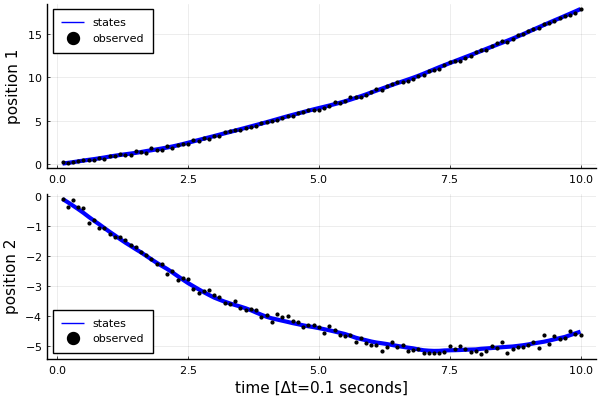

In [3]:
# Inspect data
p1 = plot((1:T).*Δt, states[1,:], linewidth=3, color="blue", xlabel="", ylabel="position 1", label="states", size=(700,400))
scatter!((1:T).*Δt, observations[1,:], color="black", markersize=2, label="observed", legend=:topleft)
p2 = plot((1:T).*Δt, states[2,:], linewidth=3, color="blue", xlabel="time [Δt="*string(Δt)*" seconds]", ylabel="position 2", label="states", size=(600,400))
scatter!((1:T).*Δt, observations[2,:], color="black", markersize=2, label="observed", legend=:bottomleft)
plot(p1,p2, layout=(2,1))

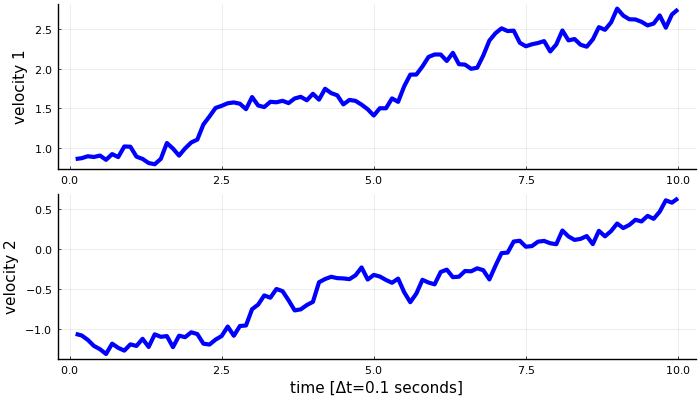

In [4]:
# Inspect data
p1 = plot((1:T).*Δt, states[3,:], linewidth=3, color="blue", xlabel="", ylabel="velocity 1", label="")
p2 = plot((1:T).*Δt, states[4,:], linewidth=3, color="blue", xlabel="time [Δt="*string(Δt)*" seconds]", ylabel="velocity 2", label="")
plot(p1,p2, layout=(2,1), size=(700,400))

### Model specification

We can convert the state transition and observation likelihood from the system dynamics to probabilistic form by integrating out the noise variables:

$$\begin{align}
x_k \sim&\ \mathcal{N}(Ax_{k-1}, Q) \\
y_k \sim&\ \mathcal{N}(Cx_k, R) \, .
\end{align}$$

The noise covariance matrices are now the covariance matrices of the stochastic state transition and likelihood. 

We will need priors for the unknown variables. We will be doing recursive estimation (filtering) in this notebook, we need only define a prior for the "previous state" variable $x_{k-1}$:

$$\begin{align} 
x_{k-1} \sim \mathcal{N}(m_k, W_k^{-1}) \, ,
\end{align}$$

where $W_k$ is a precision matrix. In Bayesian inference, we often work with precision matrices instead of covariance matrices as that tends to require less matrix inversions. We will model the unknown noise precision matrices with Wishart distributions since these are the conditionally [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) for Gaussian likelihoods:

$$\begin{align} 
Q^{-1} \sim&\ \mathcal{W}(V_Q, n_Q) \\
R^{-1} \sim&\ \mathcal{W}(V_R, n_R) \, .
\end{align}$$

With a likelihood and a set of priors, we can specify a model in a probabilistic programming language (here [ForneyLab.jl](https://github.com/biaslab/ForneyLab.jl)) and automatically infer (approximate) posteriors.

In [5]:
using ForneyLab

In [6]:
fg = FactorGraph()

# Measurement noise precision (R inverse)
@RV Ri ~ Wishart(placeholder(:V_R, dims=(2,2)), placeholder(:n_R))

# Process noise precision (Q inverse)
@RV Qi ~ Wishart(placeholder(:V_Q, dims=(4,4)), placeholder(:n_Q))

# Previous state vector
@RV x_kmin1 ~ GaussianMeanPrecision(placeholder(:m_k, dims=(4,)), placeholder(:W_k, dims=(4,4)))

# State transition
@RV x_k ~ GaussianMeanPrecision(A*x_kmin1, Qi)

# Observation likelihood
@RV y_k ~ GaussianMeanPrecision(C*x_k, Ri)

# Indicate y_k will be observed
placeholder(y_k, :y_k, dims=(2,));

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.47.1 (20210417.1919)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5941341513802636210 -->
 
 5941341513802636210 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 16663310295442059261 -->
 
 16663310295442059261 
 
 placeholder_W_k 
 
<!-- 5941341513802636210--16663310295442059261 -->
 
 5941341513802636210--16663310295442059261 
 
 W_k 
 1 out 
 3 w 
 
<!-- 10542561699812716660 -->
 
 10542561699812716660 
 
 placeholder_m_k 
 
<!-- 5941341513802636210--10542561699812716660 -->
 
 5941341513802636210--10542561699812716660 
 
 m_k 
 1 out 
 2 m 
 
<!-- 4134079115488693099 -->
 
 4134079115488693099 
 
 placeholder_V_R 
 
<!-- 8298121415515733540 -->
 
 8298121415515733540 
 
 placeholder_n_Q 
 
<!-- 7629519488406958030 -->
 
 7629519488406958030 
 
 × 
 multiplication_2 
 
<!-- 13218195618862567686 -->
 
 13218195618862567686 
 
 clamp_2 
 
<!-- 7629519488406958030--13218195618862567686 -->
 
 7629519488406958030--13218195618862567686 
 
 clamp_2 
 1 out 
 3 a 
 
<!-- 9361413941218680690 -->
 
 9361413941218680690 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 7629519488406958030--9361413941218680690 -->
 
 7629519488406958030--9361413941218680690 
 
 x_k 
 1 out 
 2 in1 
 
<!-- 7529698789946908779 -->
 
 7529698789946908779 
 
 W 
 wishart_2 
 
<!-- 7529698789946908779--8298121415515733540 -->
 
 7529698789946908779--8298121415515733540 
 
 n_Q 
 1 out 
 3 nu 
 
<!-- 7290842762548295126 -->
 
 7290842762548295126 
 
 placeholder_V_Q 
 
<!-- 7529698789946908779--7290842762548295126 -->
 
 7529698789946908779--7290842762548295126 
 
 V_Q 
 1 out 
 2 v 
 
<!-- 5025943097843373333 -->
 
 5025943097843373333 
 
 placeholder_n_R 
 
<!-- 5507685680553730972 -->
 
 5507685680553730972 
 
 clamp_1 
 
<!-- 18239885395924478431 -->
 
 18239885395924478431 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 18239885395924478431--7629519488406958030 -->
 
 18239885395924478431--7629519488406958030 
 
 variable_2 
 1 out 
 2 m 
 
<!-- 15013276262691968449 -->
 
 15013276262691968449 
 
 W 
 wishart_1 
 
<!-- 18239885395924478431--15013276262691968449 -->
 
 18239885395924478431--15013276262691968449 
 
 Ri 
 1 out 
 3 w 
 
<!-- 9361413941218680690--7529698789946908779 -->
 
 9361413941218680690--7529698789946908779 
 
 Qi 
 1 out 
 3 w 
 
<!-- 1142015846284183458 -->
 
 1142015846284183458 
 
 × 
 multiplication_1 
 
<!-- 9361413941218680690--1142015846284183458 -->
 
 9361413941218680690--1142015846284183458 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 15013276262691968449--4134079115488693099 -->
 
 15013276262691968449--4134079115488693099 
 
 V_R 
 1 out 
 2 v 
 
<!-- 15013276262691968449--5025943097843373333 -->
 
 15013276262691968449--5025943097843373333 
 
 n_R 
 1 out 
 3 nu 
 
<!-- 8317992391200949616 -->
 
 8317992391200949616 
 
 placeholder_y_k 
 
<!-- 8317992391200949616--18239885395924478431 -->
 
 8317992391200949616--18239885395924478431 
 
 y_k 
 1 out 
 1 out 
 
<!-- 1142015846284183458--5941341513802636210 -->
 
 1142015846284183458--5941341513802636210 
 
 x_kmin1 
 1 out 
 2 in1 
 
<!-- 1142015846284183458--5507685680553730972 -->
 
 1142015846284183458--5507685680553730972 
 
 clamp_1 
 1 out 
 3 a

### Compile inference algorithm

We cannot use exact Bayesian inference here and will therefore switch to an approximate inference scheme: variational message passing.

In [7]:
# Define a factorization for the posterior
q = PosteriorFactorization(x_k, x_kmin1, Qi, Ri, ids=[:x_k, :x_kmin1, :Qi, :Ri])

# Define a variational message passing procedure
algorithm = messagePassingAlgorithm([x_k, x_kmin1, Qi, Ri], q)

# Compile message passing procedure to an inference algorithm
code = algorithmSourceCode(algorithm);

# Import compiled functions to workspace
eval(Meta.parse(code));

# Print compiled functions (uncomment when desired)
# println(code)

### Execute inference algorithm

We execute the algorithm in an online fashion: after each timestep the posteriors for the state and noise precisions are used as priors for the next timestep.

In [8]:
# Parameters for prior distributions
m_x_0 = [0., 0., 1., -1.]
W_x_0 = 10. .* Matrix{Float64}(I, 4,4)
V_Q_0 = 10 .*Matrix{Float64}(I, 4,4)
n_Q_0 = 1.0
V_R_0 = Matrix{Float64}(I, 2,2)
n_R_0 = 100.0;

In [9]:
# Number of iterations
num_iterations = 5

# Initialize arrays for storing parameter estimates
m_x_k = zeros(4,T)
W_x_k = zeros(4,4,T)
V_Q_k = zeros(4,4,T)
n_Q_k = zeros(T,)
V_R_k = zeros(2,2,T)
n_R_k = zeros(T,)

# Initialize previous parameter estimates
m_x_kmin1 = m_x_0
W_x_kmin1 = W_x_0
V_Q_kmin1 = V_Q_0
n_Q_kmin1 = n_Q_0
V_R_kmin1 = V_R_0
n_R_kmin1 = n_R_0

# Initialize data dictionary
data = Dict()

# Initialize marginal distributions
marginals = Dict()
marginals[:x_kmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_0, w=W_x_0)
marginals[:x_k] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_0, w=W_x_0)
marginals[:Qi] = ProbabilityDistribution(Wishart, v=V_Q_0, nu=n_Q_0)
marginals[:Ri] = ProbabilityDistribution(Wishart, v=V_R_0, nu=n_R_0)

# Recursive estimation procedure (posteriors at k => priors at k+1)
@showprogress for k = 1:T
    
    # Store data for current time-step
    data[:y_k] = observations[:,k]
    data[:m_k] = m_x_kmin1
    data[:W_k] = W_x_kmin1
    data[:V_Q] = V_Q_kmin1
    data[:n_Q] = n_Q_kmin1
    data[:V_R] = V_R_kmin1
    data[:n_R] = n_R_kmin1
    
    # Coordinate descent
    for kk = 1:num_iterations
        
        # Update recognition factors
        stepx_kmin1!(data, marginals)
        stepx_k!(data, marginals)
        stepQi!(data, marginals)
        stepRi!(data, marginals)
        
    end
    
    # Update book-keeping
    m_x_kmin1 = m_x_k[:,k] = ForneyLab.unsafeMean(marginals[:x_k])
    W_x_kmin1 = W_x_k[:,:,k] = ForneyLab.unsafePrecision(marginals[:x_k])
    V_Q_kmin1 = V_Q_k[:,:,k] = marginals[:Qi].params[:v]
    n_Q_kmin1 = n_Q_k[k] = marginals[:Qi].params[:nu]
    V_R_kmin1 = V_R_k[:,:,k] = marginals[:Ri].params[:v]
    n_R_kmin1 = n_R_k[k] = marginals[:Ri].params[:nu]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


### Inspect results
We can plot the estimates of the position and velocity over time, including the uncertainty of the estimates.

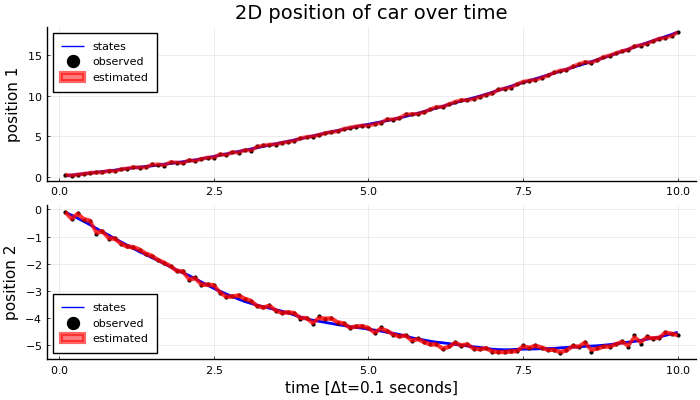

In [10]:
# Inspect data
p1 = plot((1:T).*Δt, states[1,:], linewidth=2, color="blue", xlabel="", ylabel="position 1", label="states")
scatter!((1:T).*Δt, observations[1,:], color="black", markersize=2, label="observed", legend=:topleft, title="2D position of car over time")
plot!((1:T).*Δt, m_x_k[1,:], linewidth=3, color="red", ribbon=[sqrt.(inv.(W_x_k[1,1,:])) sqrt.(inv.(W_x_k[1,1,:]))], alpha=0.6, label="estimated")
p2 = plot((1:T).*Δt, states[2,:], linewidth=2, color="blue", xlabel="time [Δt="*string(Δt)*" seconds]", ylabel="position 2", label="states")
scatter!((1:T).*Δt, observations[2,:], color="black", markersize=2, label="observed", legend=:bottomleft)
plot!((1:T).*Δt, m_x_k[2,:], linewidth=3, color="red", ribbon=[sqrt.(inv.(W_x_k[2,2,:])) sqrt.(inv.(W_x_k[2,2,:]))], alpha=0.6, label="estimated")
plot(p1,p2, layout=(2,1), size=(700,400))

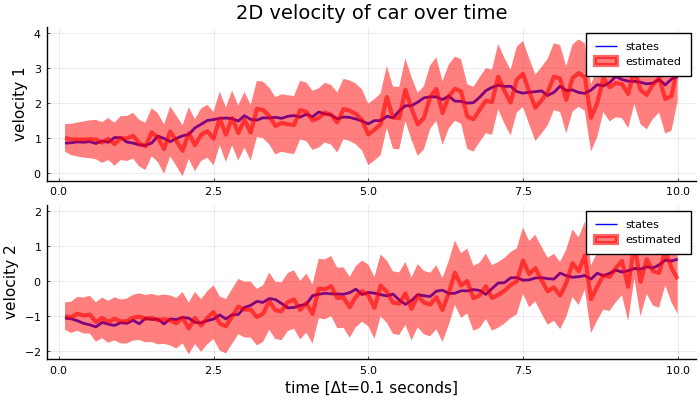

In [11]:
# Inspect data
p1 = plot((1:T).*Δt, states[3,:], linewidth=2, color="blue", xlabel="", ylabel="velocity 1", label="states", title="2D velocity of car over time")
plot!((1:T).*Δt, m_x_k[3,:], linewidth=3, color="red", ribbon=[sqrt.(inv.(W_x_k[3,3,:])) sqrt.(inv.(W_x_k[3,3,:]))], alpha=0.6, label="estimated")
p2 = plot((1:T).*Δt, states[4,:], linewidth=2, color="blue", xlabel="time [Δt="*string(Δt)*" seconds]", ylabel="velocity 2", label="states")
plot!((1:T).*Δt, m_x_k[4,:], linewidth=3, color="red", ribbon=[sqrt.(inv.(W_x_k[4,4,:])) sqrt.(inv.(W_x_k[4,4,:]))], alpha=0.6, label="estimated")
plot(p1,p2, layout=(2,1), size=(700,400))

Both the positions and velocities are nicely tracked.